<span style="font-size: 14pt">MIPT, Advanced ML, Autumn 2017</span>

<span style="font-size: 16pt"> Seminar #3: ARIMAX, Compositions

<span style="color:blue; font-size: 12pt">Alexey Romanenko </span>,
<span style="color:blue; font-size: 12pt; font-family: 'Verdana'">alexromsput@gmail.com</span>

**Key words:** 
    - ARIMAX models, composition of forecasting algorigthms

<h3> Plan </h3>
  * **HW1 solution** (20 minutes)
     
  * ** ARIMAX for energy consumption ** (30 minutes)
      - Energy cosumtion data
      - Forecasting with ARMAX,
      - Forecasting with SARIMAX
     
  * **Practice: realize compositions: ** (30 minutes)</span> 
     - Adaptive Selection  
     - Adaptive Composition 
     - <span style="color:orange; font-size: 10pt"> Aggregation Algorithm </span> (self-study)

In [1]:
import numpy as np
from datetime import datetime, timedelta
import pylab
import matplotlib.pyplot as plt
from matplotlib import gridspec
import pandas as pd
import math
import pandas.tseries.offsets as ofs
from scipy import stats
import statsmodels.api as sm
from statsmodels.tsa import stattools

import warnings as w
import plotly.plotly as py
from IPython.display import Image

from utils import qualityMACAPE, qualityRMSE, InitExponentialSmoothing, AdaptiveExponentialSmoothing

%matplotlib inline

C:\Users\rusrom.EUROPE\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


<h1 align="center"> HW1 solution </h1>

* Discuss Check Questions
* Look at realization 

<h1 align="center"> ARIMAX for energy consumption </h1>

## Energy Consumption

In [5]:
# energy_ts = pd.read_csv('./data/energy_consump.csv', sep=',', decimal='.', parse_dates={'Timestamp': pd.to_datetime('Date', errors='coerce')}, index_col='Timestamp')
energy_ts = pd.read_csv('../2_ts_arima/data/energy_consump.csv', sep=',', decimal='.', parse_dates=True, dayfirst=True, index_col='Date')
energy_ts.index.names=['Timestamp']
energy_ts.head()

,Hub,ZSP,EnergyConsump,Temp1,Temp2,Temp3,Temp4,Temp5,Temp6,Temp7,Saturday,Sunday,Temp1_South_Less,Temp2_South_Less,Temp3_South_Less,Temp4_South_Less,Temp1_South_Gr,Temp2_South_Gr,Temp3_South_Gr,Temp4_South_Gr
Timestamp,,,,,,,,,,,,,,,,,,,,
2010-01-01,Center,FZSZOE27,147487.171,-17.8,-16.9,NaN,NaN,NaN,NaN,NaN,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-02,Center,FZSZOE27,155433.800,-17.8,-20.3,NaN,NaN,NaN,NaN,NaN,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-03,Center,FZSZOE27,164140.232,-16.4,-24.0,NaN,NaN,NaN,NaN,NaN,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-04,Center,FZSZOE27,171382.848,-10.2,-15.7,NaN,NaN,NaN,NaN,NaN,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-05,Center,FZSZOE27,170188.290,-7.2,-8.8,NaN,NaN,NaN,NaN,NaN,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# Filter only Hub=Center and ZSP=FZSZOE27
energy_ts= energy_ts[(energy_ts['ZSP']=='FZSZOE27') & (energy_ts['Hub']=='Center')]
energy_ts.tail()

,Hub,ZSP,EnergyConsump,Temp1,Temp2,Temp3,Temp4,Temp5,Temp6,Temp7,Saturday,Sunday,Temp1_South_Less,Temp2_South_Less,Temp3_South_Less,Temp4_South_Less,Temp1_South_Gr,Temp2_South_Gr,Temp3_South_Gr,Temp4_South_Gr
Timestamp,,,,,,,,,,,,,,,,,,,,
2015-05-23,Center,FZSZOE27,NaN,11.7,11.9,NaN,NaN,NaN,NaN,NaN,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-05-24,Center,FZSZOE27,NaN,12.4,12.8,NaN,NaN,NaN,NaN,NaN,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-05-25,Center,FZSZOE27,NaN,16.2,15.4,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-05-26,Center,FZSZOE27,NaN,18.7,17.3,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-05-27,Center,FZSZOE27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


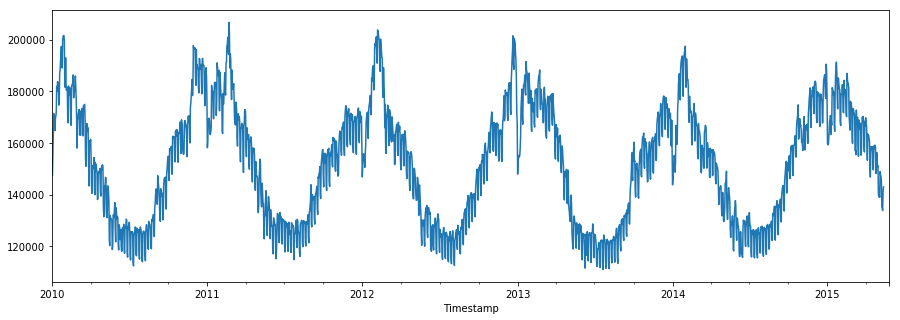

In [7]:
# See Year-Seasonality
energy_ts['EnergyConsump'].plot(figsize=(15,5))

# uncomment to save the figure
# plt.savefig('../Lecture_TS_Forecasting/pic/Energy_YearSeasonality.eps', bbox_inches='tight', pad_inches=0, format='eps', dpi=1000) 

**Questions** 
    - Which components of TS do you see?
    - Are there any dependences on other variables?
    - Is that TS stationary? Why?

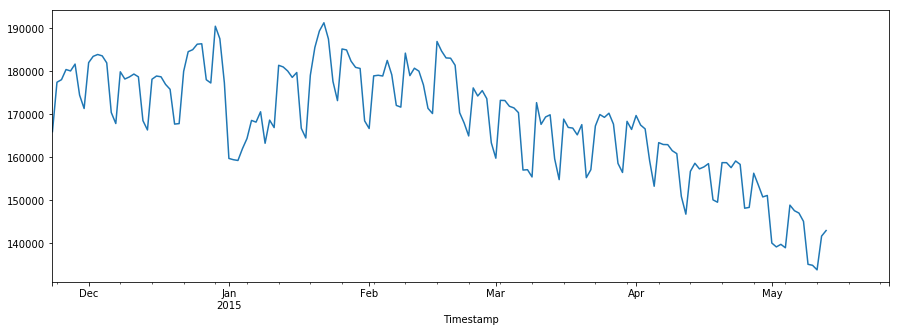

In [8]:
# See Week easonality
energy_ts['EnergyConsump'].tail(186).plot(figsize=(15,5))

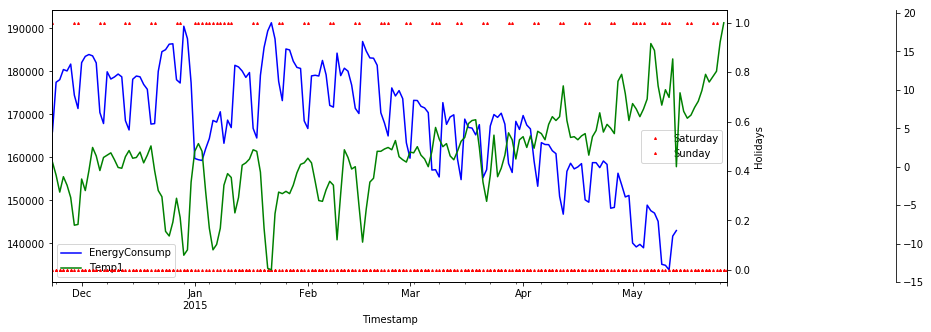

In [9]:
# See dependence on other varibales
fig, ax = plt.subplots(figsize=(15,5))
ax2, ax3 = ax.twinx(), ax.twinx()
ax2.set_ylabel('Holidays')
rspine = ax3.spines['right']
rspine.set_position(('axes', 1.25))
ax3.set_frame_on(True)
ax3.patch.set_visible(False)
fig.subplots_adjust(right=0.75)

energy_ts['EnergyConsump'].tail(186).plot(ax = ax,  style='b-')
energy_ts[['Saturday', 'Sunday']].tail(186).plot(ax = ax2, style='r', marker = '^', markersize = 2.0, linewidth=0.0)
energy_ts['Temp1'].tail(186).plot(ax = ax3,  style='g-')

lines = ax.get_lines() + ax3.get_lines() #  ax2.get_lines() 
ax.legend(lines, [l.get_label() for l in lines], loc='lower left')
# uncomment to save the figure
# plt.savefig('../Lecture_TS_Forecasting/pic/Energy_WeekSeasonality.png', bbox_inches='tight', pad_inches=0) # 
# plt.savefig('../Lecture_TS_Forecasting/pic/Energy_WeekSeasonality.eps', bbox_inches='tight', pad_inches=0, format='eps', dpi=1000) 

In [83]:
# Stationary test
kpss_stat= stattools.kpss(np.array(dta))
print('The KPSS test statistic %f, \npvalue: %.2f \nmaximal Lag: %i \ntable distribution: %s' % 
      (kpss_stat[0], kpss_stat[1], kpss_stat[2], kpss_stat[3]))

The KPSS test statistic 0.509193, 
pvalue: 0.04 
maximal Lag: 20 
table distribution: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


# Forecasting with ARMAX

** Question: **
* What is SARIMA?
* What is ARIMAX?
* Give examples of TS that depends on exogenious variables.

## SARIMA

SARIMA $(p,d,q)\times (P,D,Q)_s$:

### $$ (1-B)^{d} (1-B^s)^{\color{red}{D}} y_t=z_t$$

### $$z_t = \underbrace{\mu +\sum_{i=1}^{p} \alpha_i \left(\sum_{k=1}^{\color{red}{P}}\delta_pB^{\color{red}{s}\cdot k}\right) z_{t-i}}\limits_{AR} +\underbrace{\sum_{j=1}^{q} \beta_j\left(\sum_{l=1}^{\color{red}{Q}}\gamma_jB^{\color{red}{s}\cdot l}\right)\varepsilon_{t-j}}\limits_{MA}+\varepsilon_t$$

In operator view:

### $$\Phi_P\left(B^s\right)\phi_p\left(B\right)\nabla^D_s \nabla^d z_t = \Theta_Q\left(B^s\right)\theta_q\left(B\right)\varepsilon_t$$

ARIMAX $(p,d,q)\times (P, D, Q)_s \times \{x_j\}_{j=1}^k$
### $$\Phi_P\left(B^s\right)\phi_p\left(B\right)\nabla^D_s \nabla^d z_t = \Theta_Q\left(B^s\right)\theta_q\left(B\right)\varepsilon_t$$

###    $$+$$

###    $$y_t = \sum\limits_{j=1}^k \beta_j x_{jt} + z_t$$

###    $$=$$

###    $$\Phi_P\left(B^s\right)\phi_p\left(B\right)\nabla^D_s \nabla^d \left(y_t - \sum\limits_{j=1}^k \beta_j x_{jt}\right) = \Theta_Q\left(B^s\right)\theta_q\left(B\right)\varepsilon_t.$$

** Scheme for forecasting with ARIMAX**: 
* 0) Check stationarity of TS and exogenios variables:
   - if there is non-stationarity, shift to differences; 
   - for the sake of easier interpretation the difference operator should also be applied to exogenious variables;
   - <span style="color:red">start always with seasonal differencing!</span>
* 1) A regression is built for the differences of TS and exogenious variables
* 2) A suitable model $ARMA\left(p_1,q_1\right)$ for residuals of regression $\hat{z}_t$ is selected.
* 3) Regression is rebuilt in supposition that the errors are described by model $ARMA\left(p_1,q_1\right)$.
* 4) Residuals $\hat{\varepsilon}_t$ are analyzed.
* 5) Forecast is build for initial TS 

with SARIMA:
* A regression is built for the time series of differences 
   - errors are described by a model of initial approximation;
   - as a rule it is either $AR(2)$ or $SARMA(2,0)\times(1,0)_s$

In [10]:
energy_ts.columns

Index(['Hub', 'ZSP', 'EnergyConsump', 'Temp1', 'Temp2', 'Temp3', 'Temp4',
       'Temp5', 'Temp6', 'Temp7', 'Saturday', 'Sunday', 'Temp1_South_Less',
       'Temp2_South_Less', 'Temp3_South_Less', 'Temp4_South_Less',
       'Temp1_South_Gr', 'Temp2_South_Gr', 'Temp3_South_Gr', 'Temp4_South_Gr'],
      dtype='object')

In [27]:
# replace all NaN values
dta = energy_ts[['EnergyConsump','Temp1', 'Temp2', 'Saturday','Sunday']].dropna()

## 0) Check stationarity of TS and exogenios variables

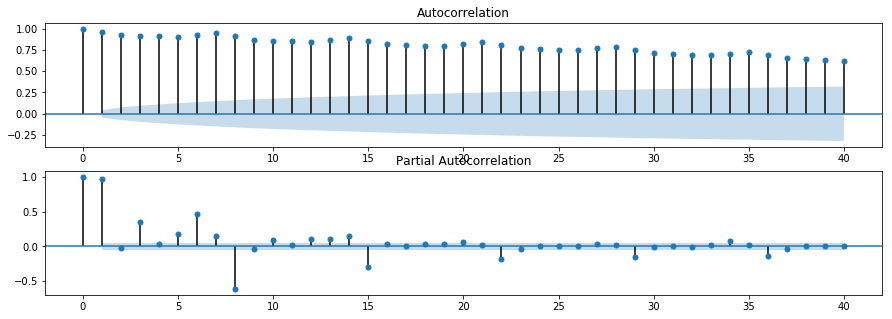

In [28]:
# acf
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(dta['EnergyConsump'].values.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(dta['EnergyConsump'].values.squeeze(), lags=40, ax=ax2)

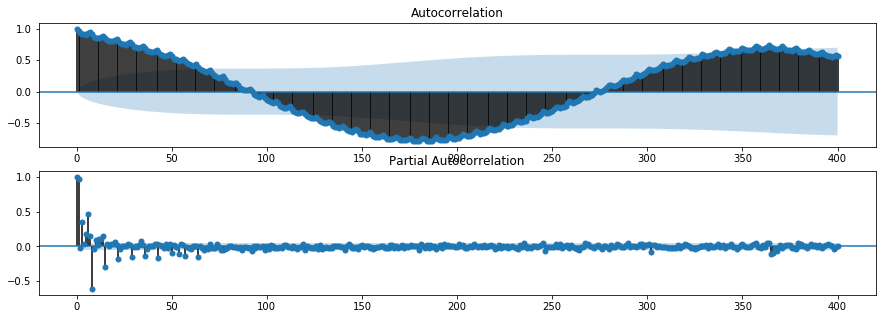

In [29]:
# acf
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(dta['EnergyConsump'].values.squeeze(), lags=400, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(dta['EnergyConsump'].values.squeeze(), lags=400, ax=ax2)

** Question **
 - Can we use thiss ACF, PACF for choosing p,q?

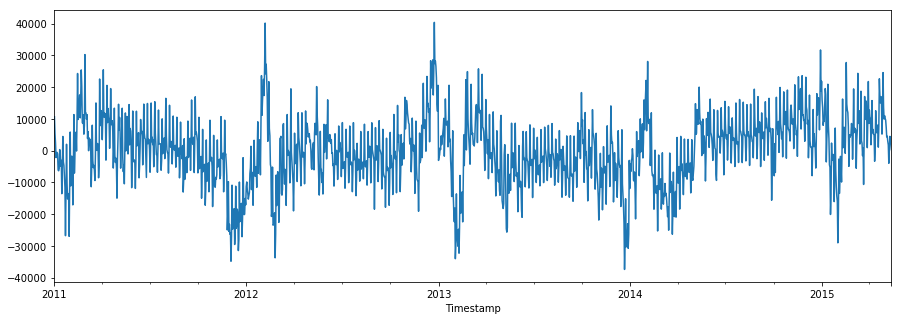

In [30]:
# Differencing
p = 365
shift365_energy = (dta - dta.shift(p))[p:]
shift365_energy['EnergyConsump'].plot(figsize=(15,5))

** Question:**
 * Is this TS stationary?
   - Hint: see picture below.

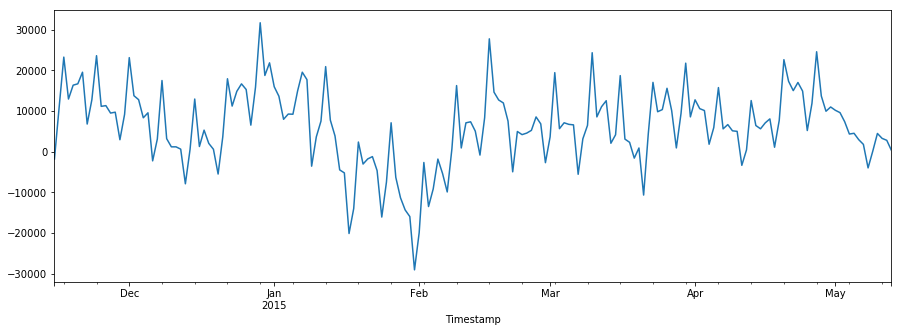

In [31]:
shift365_energy['EnergyConsump'].tail(180).plot(figsize=(15,5))

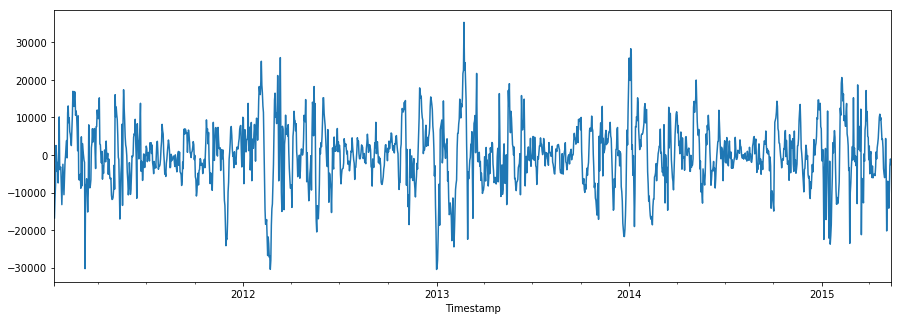

In [32]:
p=7
dif7_shift365_energy = (shift365_energy - shift365_energy.shift(p))[p:]
dif7_shift365_energy['EnergyConsump'].plot(figsize=(15,5))

** Question:**
 * Is this TS stationary?

In [33]:
# Stationary test
kpss_stat= stattools.kpss(np.array(dif7_shift365_energy['EnergyConsump']))
print('The KPSS test statistic %f, \npvalue: %.2f \nmaximal Lag: %i \ntable distribution: %s' % 
      (kpss_stat[0], kpss_stat[1], kpss_stat[2], kpss_stat[3]))

The KPSS test statistic 0.009940, 
pvalue: 0.10 
maximal Lag: 24 
table distribution: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


C:\Users\rusrom.EUROPE\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1260: InterpolationWarning:

p-value is greater than the indicated p-value



* It seems that TS is stationary
** Question: ** 
  * Are TS for exogenious variables stationary?

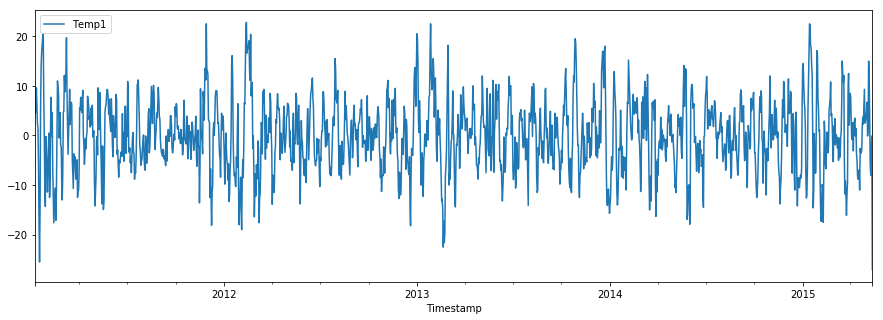

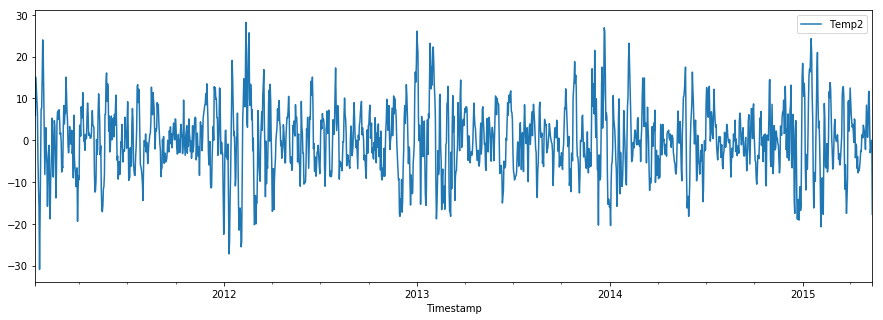

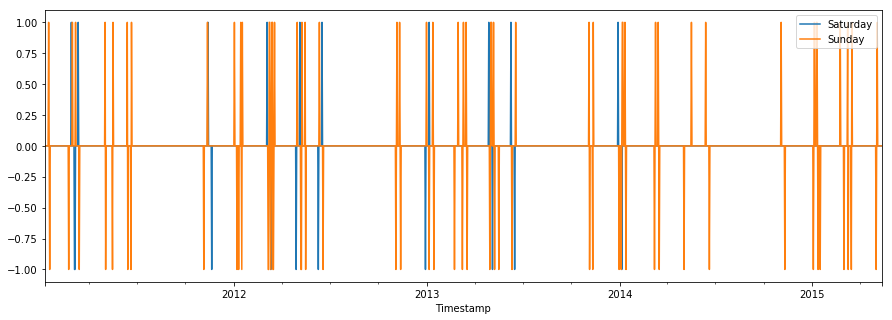

In [41]:
# plot grap for the individual variables
dif7_shift365_energy[['Temp1']].plot(figsize=(15,5))
dif7_shift365_energy[['Temp2']].plot(figsize=(15,5))
dif7_shift365_energy[['Saturday', 'Sunday']].plot(figsize=(15,5))

In [45]:
# TODO: build KPSS test for all exog variables
kpss_stat= stattools.kpss(np.array(dif7_shift365_energy['Temp1']))
print('The KPSS test statistic %f, \npvalue: %.2f \nmaximal Lag: %i \ntable distribution: %s' % 
      (kpss_stat[0], kpss_stat[1], kpss_stat[2], kpss_stat[3]))

The KPSS test statistic 0.008394, 
pvalue: 0.10 
maximal Lag: 24 
table distribution: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


C:\Users\rusrom.EUROPE\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1260: InterpolationWarning:

p-value is greater than the indicated p-value



## 1) A regression is built for the differences of TS and exogenious variables

In [47]:
# apply regression for defferenced TS
exogs = dif7_shift365_energy[['Temp1', 'Temp2', 'Saturday','Sunday']][dif7_shift365_energy.index<'2015-05-01']
extra_exogs = dif7_shift365_energy[['Temp1', 'Temp2', 'Saturday','Sunday']]
ts = dif7_shift365_energy[['EnergyConsump']][dif7_shift365_energy.index<'2015-05-01']

In [68]:
# Only regressors
arima_mod000 = sm.tsa.ARIMA(ts, (0,0,0), exog=exogs).fit()
print(arima_mod000.params)
print(arima_mod000.aic, arima_mod000.bic, arima_mod000.hqic)

const          36.114920
Temp1        -455.754651
Temp2         -94.747830
Saturday    -8821.376321
Sunday     -10395.544799
dtype: float64
32194.2320784 32226.4003309 32206.1870399


## 2) A suitable model  $ARMA(p1,q1)$ for residuals of regression  $z_t$  is selected 
** Caution: we forget seasonality **

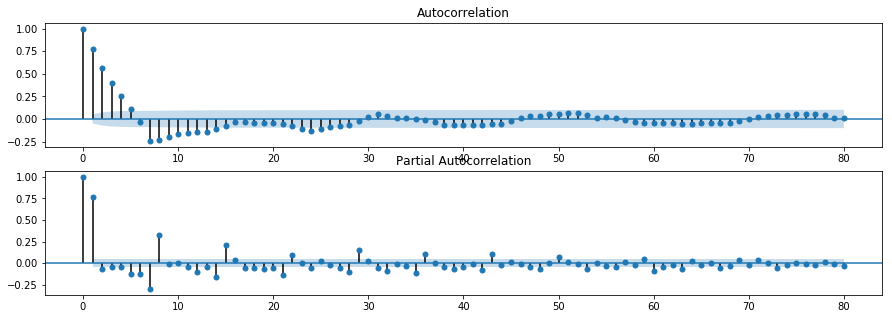

In [51]:
# acf for difference TS
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(arima_mod000.resid.values.squeeze(), lags=80, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(arima_mod000.resid.values.squeeze(), lags=80, ax=ax2)

** Question:**
   * What are candidates for p and q?
       - candidates values for p - 1 
       - candidates values for q - 7 

## 3) Regression is rebuilt in supposition that the errors are described by model ARMA(p1,q1)

C:\Users\rusrom.EUROPE\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\base\model.py:473: HessianInversionWarning:

Inverting hessian failed, no bse or cov_params available

C:\Users\rusrom.EUROPE\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



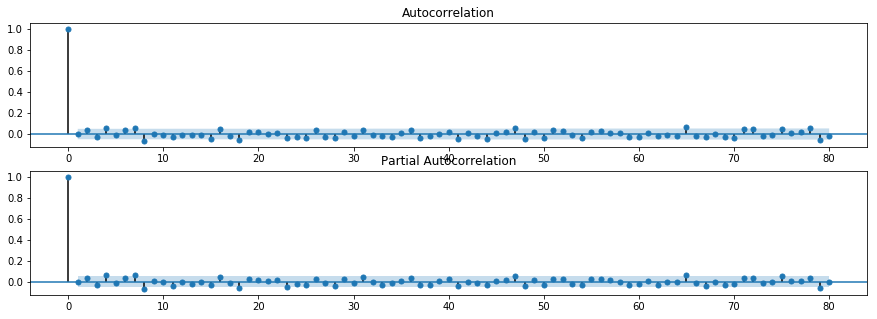

In [52]:
arima_mod107 = sm.tsa.ARIMA(ts, (1,0,7), exog=exogs).fit()
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(arima_mod107.resid.values.squeeze(), lags=80, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(arima_mod107.resid.values.squeeze(), lags=80, ax=ax2)

* Is seems  there is no more lags to take into account
* Let's analyse resudials

## 4) Residuals $\varepsilon_t$  are analyzed.

### Stationarity

In [53]:
# Kwiatkowski–Phillips–Schmidt–Shin
kpss_stat= stattools.kpss(arima_mod107.resid.values)
print('The KPSS test statistic %f, \npvalue: %.2f \nmaximal Lag: %i \ntable distribution: %s' % 
      (kpss_stat[0], kpss_stat[1], kpss_stat[2], kpss_stat[3]))

The KPSS test statistic 0.281045, 
pvalue: 0.10 
maximal Lag: 24 
table distribution: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


C:\Users\rusrom.EUROPE\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1260: InterpolationWarning:

p-value is greater than the indicated p-value



* Residuals are stationary

### Autocorrelation test

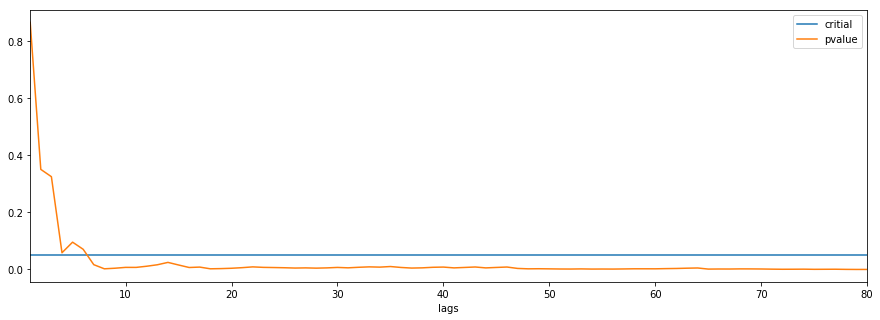

In [57]:
# Ljung-Box test 
pd.DataFrame({'lags':range(1,81,1), 'pvalue':sm.stats.diagnostic.acorr_ljungbox(arima_mod107.resid.values, lags=80)[1], 
              'critial':np.array([0.05]*80)}).set_index('lags').plot(figsize=(15,5))
# plt.plot(sm.stats.diagnostic.acorr_ljungbox(arma_mod00.resid.values, lags=30)[1],'b')

For lags 1-6 residuals are not correlated, but for lags 7 and grater seems residuals are correlated

### Unbiasedness test

In [58]:
# Darbin_Watson statistic
sm.stats.durbin_watson(arima_mod107.resid.values)

1.9894606433277848

Residuals are not biased!

### Normality test

In [60]:
stats.normaltest(arima_mod107.resid)

NormaltestResult(statistic=117.77930740670955, pvalue=2.6579594769708018e-26)

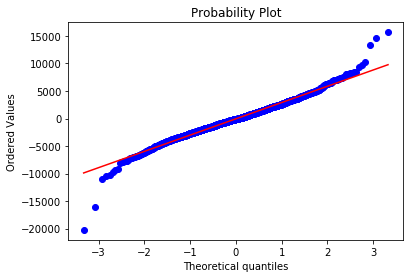

In [62]:
## q-qPlot
fig = plt.figure()
res = stats.probplot(arima_mod107.resid, dist="norm", plot=pylab)

* Hypothesis of normality can be rejected

In [63]:
print(arima_mod107.summary())

                              ARMA Model Results                              
Dep. Variable:          EnergyConsump   No. Observations:                 1574
Model:                     ARMA(1, 7)   Log Likelihood              -14814.580
Method:                       css-mle   S.D. of innovations           2943.728
Date:                Sun, 24 Sep 2017   AIC                          29657.160
Time:                        19:21:47   BIC                          29732.219
Sample:                    01-08-2011   HQIC                         29685.055
                         - 04-30-2015                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  39.9348     52.097      0.767      0.443     -62.173     142.043
Temp1                 -87.4075     27.312     -3.200      0.001    -140.939     -33.876
Temp2           

## 5) Forecast is build for initial TS

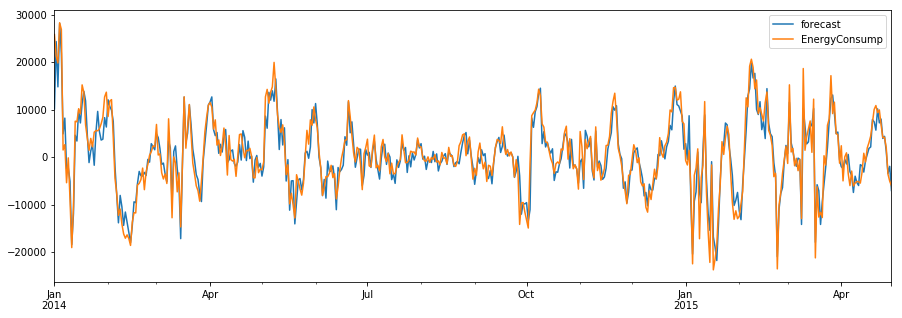

In [64]:
fig, ax = plt.subplots(figsize=(15,5),  linewidth=3.0)
fig = arima_mod107.plot_predict(start='2014-01-01', end='2015-04-30', ax=ax)
# legend = ax.legend(loc='upper left')

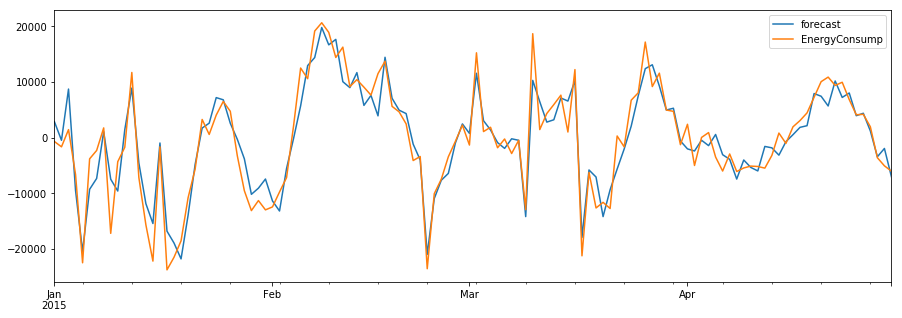

In [65]:
fig, ax = plt.subplots(figsize=(15,5),  linewidth=3.0)
fig = arima_mod107.plot_predict(start='2015-01-01', end='2015-04-30', ax=ax)

In [66]:
# fig, ax = plt.subplots(figsize=(15,8),  linewidth=3.0)
# fig = arima_mod710_ex.plot_forecast(185)
frc = arima_mod107.forecast(steps = 13, exog = extra_exogs[extra_exogs.index>='2015-05-01'])

In [80]:
frc_arimax = extra_exogs[extra_exogs.index>='2015-05-01']
frc_arimax['FRC'] = frc[0]
# frc_arimax['EnergyConsump'] = ts[ts.index>='2015-05-01'] 

C:\Users\rusrom.EUROPE\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



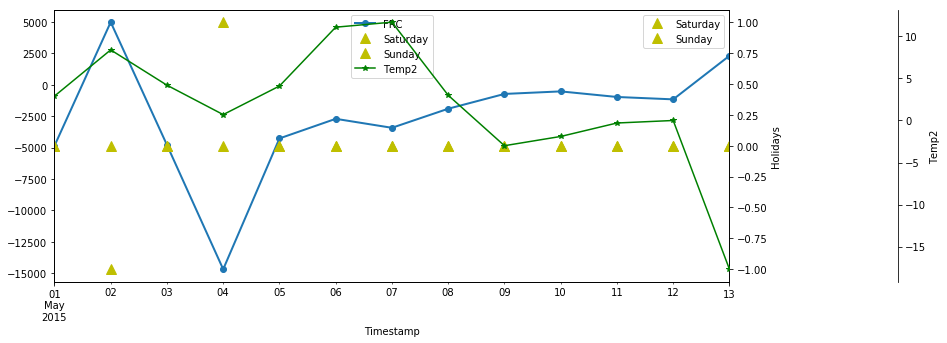

In [81]:
fig, ax = plt.subplots(figsize=(15,5))

ax2, ax3 = ax.twinx(), ax.twinx()
ax2.set_ylabel('Holidays')
rspine = ax3.spines['right']
rspine.set_position(('axes', 1.25))
ax3.set_frame_on(True)
ax3.patch.set_visible(False)
ax3.set_ylabel('Temp2')
fig.subplots_adjust(right=0.75)

frc_arimax[['FRC']].tail(186).plot(ax = ax,marker = 'o', linewidth=2.0)
frc_arimax[['Saturday', 'Sunday']].tail(186).plot(ax = ax2, style='y', marker = '^', markersize = 10.0, linewidth=0.0)
frc_arimax['Temp2'].tail(186).plot(ax = ax3,  style='g-', marker='*')

lines = ax.get_lines() + ax2.get_lines() + ax3.get_lines()
ax.legend(lines, [l.get_label() for l in lines], loc='upper center')

In [ ]:
# Practice: build the forecast of original TS


In [ ]:
# Practice: calculate MAPE for dates > 2015-05-01


<h1 align="center">Forecasting with SARIMAX </h1>

** Question: ** 
 * What is the period of seasonality for this TS? Another way to say: what are specifications of ARIMA model for this TS:
    - ARIMA (2,0,7)x(1,0,1)_365
    - ARIMA (2,0,0)x(52,0,52)_7

We will apply p=7 to ts shift365_energy instead of p=365 to orifinal ts
    - use additional exogenious variable that correspond seasonality p=365

## 1) A regression is built for the differences of TS and exogenious variables

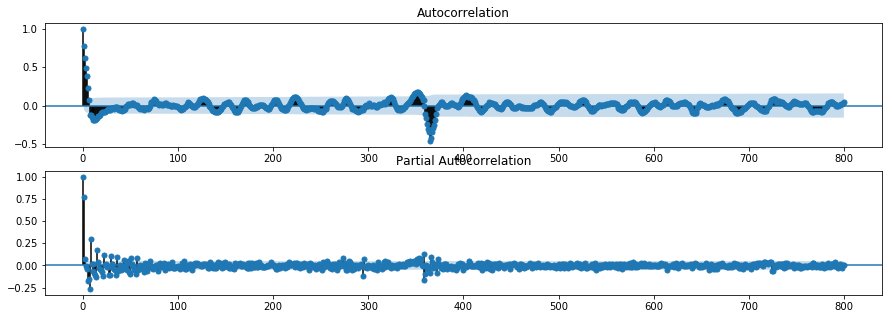

In [85]:
# acf for stationary TS
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(dif7_shift365_energy['EnergyConsump'].values.squeeze(), lags=800, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(dif7_shift365_energy['EnergyConsump'].values.squeeze(), lags=800, ax=ax2)

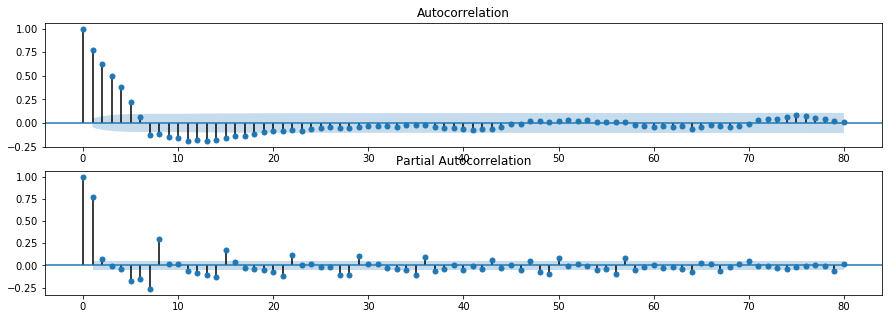

In [82]:
# acf for stationary TS
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(dif7_shift365_energy['EnergyConsump'].values.squeeze(), lags=80, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(dif7_shift365_energy['EnergyConsump'].values.squeeze(), lags=80, ax=ax2)

** Question:**
* What are candidates for p and q?
    - candidates values for p - 1, 
    - candidates values for q - 0,
    - candidates values for P - 1, 2, 52
    - candidates values for Q - 1, 2, 52
* Apply SARIMA to shift365_energy TS: 
    - what is value for d, D?

In [87]:
# apply regression for defferenced TS
exogs = shift365_energy[['Temp1', 'Temp2', 'Saturday','Sunday']][shift365_energy.index<'2015-05-01']
extra_exogs = shift365_energy[['Temp1', 'Temp2', 'Saturday','Sunday']]
ts = shift365_energy[['EnergyConsump']][shift365_energy.index<'2015-05-01']

## 2) A suitable model  $ARMA(p1,q1)$ for residuals of regression  $z_t$  is selected 

In [127]:
def my_func(ts, p,d,q,P,D,Q): 
    try:
        mod = sm.tsa.statespace.SARIMAX(ts, trend='n', order=(p,d,q), seasonal_order=(P,D,Q,7))
        results = mod.fit()
        return("sarimax_%i%i%i_%i%i%i: aic=%f, bic=%f, hqic=%f " % (p,d,q,P,D,Q, 
               results.aic, results.bic, results.hqic))
    except Exception:
        return ("sarimax_%i%i%i_%i%i%i: can't fit model " % (p,d,q,P,D,Q))    

In [130]:
from sklearn.grid_search import ParameterGrid
param_grid = {'p': [1], 'd' : [0],
             'q': [0], 'P' : [1,2],
             'D': [1], 'Q' : [1,2,52]}

grid = ParameterGrid(param_grid)

for params in grid:
    print(my_func(ts,params['p'], params['d'], params['q'], params['P'], params['D'], params['Q']))

sarimax_100_111: aic=30629.723649, bic=30651.186900, hqic=30637.698444 


C:\Users\rusrom.EUROPE\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



sarimax_100_112: aic=30809.013701, bic=30835.842766, hqic=30818.982195 
sarimax_100_1152: can't fit model 


C:\Users\rusrom.EUROPE\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



sarimax_100_211: aic=30631.587209, bic=30658.416273, hqic=30641.555703 


C:\Users\rusrom.EUROPE\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



sarimax_100_212: aic=30810.265846, bic=30842.460723, hqic=30822.228038 
sarimax_100_2152: can't fit model 


In [133]:
# Caution takes a lot of time
param_grid = {'p': [1], 'd' : [0],
             'q': [0], 'P' : [52],
             'D': [1], 'Q' : [1, 2,52]}

grid = ParameterGrid(param_grid)

for params in grid:
    print(my_func(ts,params['p'], params['d'], params['q'], params['P'], params['D'], params['Q']))

KeyboardInterrupt: 

## 3) Regression is rebuilt in supposition that the errors are described by model ARMA(p1,q1)

In [143]:
sarimax_100_111 = sm.tsa.statespace.SARIMAX(ts, trend='n', 
                                            order=(1,0,0), seasonal_order=(1,1,1,7), exog=exogs).fit()

C:\Users\rusrom.EUROPE\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



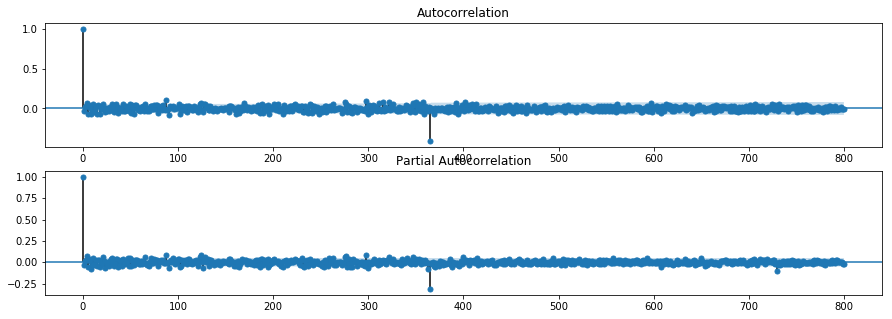

In [140]:
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(sarimax_100_111.resid.values.squeeze(), lags=800, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(sarimax_100_111.resid.values.squeeze(), lags=800, ax=ax2)

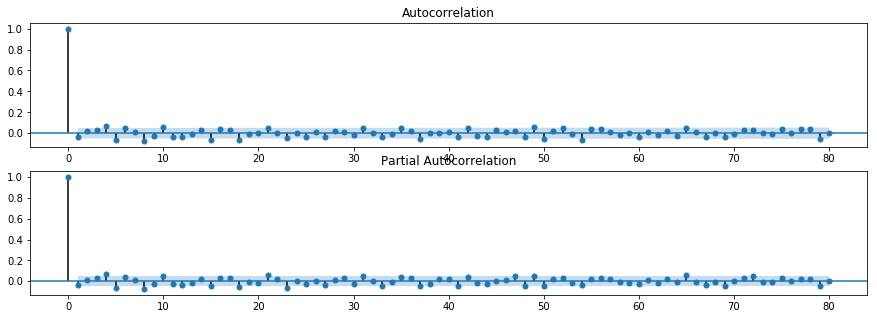

In [139]:
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(sarimax_100_111.resid.values.squeeze(), lags=80, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(sarimax_100_111.resid.values.squeeze(), lags=80, ax=ax2)

* Let's fit model for q=5

In [142]:
sarimax_105_111 = sm.tsa.statespace.SARIMAX(ts, trend='n', 
                                            order=(1,0,5), seasonal_order=(1,1,1,7), exog=exogs).fit()

C:\Users\rusrom.EUROPE\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\tools.py:405: RuntimeWarning:

invalid value encountered in sqrt



ValueError: array must not contain infs or NaNs

* Is seems  there is no more lags to take into account (insead of lag 365 - you need to add in into exogenious) 
* Let's analyse resudials

## 4) Residuals $\varepsilon_t$  are analyzed.

### Stationarity

In [144]:
# Kwiatkowski–Phillips–Schmidt–Shin
kpss_stat= stattools.kpss(sarimax_100_111.resid.values)
print('The KPSS test statistic %f, \npvalue: %.2f \nmaximal Lag: %i \ntable distribution: %s' % 
      (kpss_stat[0], kpss_stat[1], kpss_stat[2], kpss_stat[3]))

The KPSS test statistic 0.377998, 
pvalue: 0.09 
maximal Lag: 24 
table distribution: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


* Residuals are stationary

### Autocorrelation test

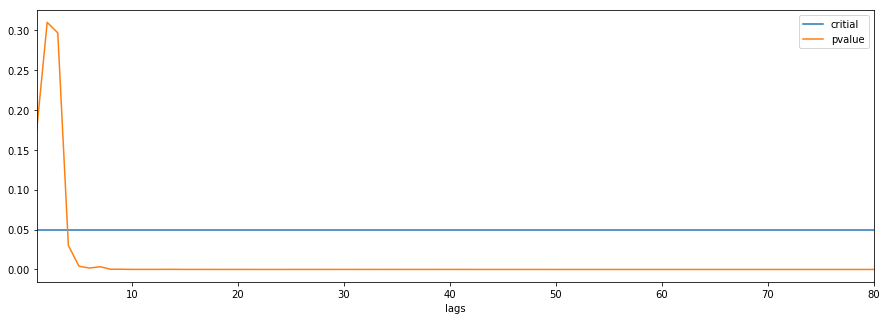

In [146]:
# Ljung-Box test 
pd.DataFrame({'lags':range(1,81,1), 'pvalue':sm.stats.diagnostic.acorr_ljungbox(sarimax_100_111.resid.values, lags=80)[1], 
              'critial':np.array([0.05]*80)}).set_index('lags').plot(figsize=(15,5))
# plt.plot(sm.stats.diagnostic.acorr_ljungbox(arma_mod00.resid.values, lags=30)[1],'b')

For lags 1-6 residuals are not correlated, but for lags 7 and grater seems residuals are correlated

### Unbiasedness test

In [147]:
# Darbin_Watson statistic
sm.stats.durbin_watson(sarimax_100_111.resid.values)

2.0623514566086008

Residuals are not biased!

### Normality test

In [148]:
stats.normaltest(sarimax_100_111.resid)

NormaltestResult(statistic=124.79153577361377, pvalue=7.9774173364255483e-28)

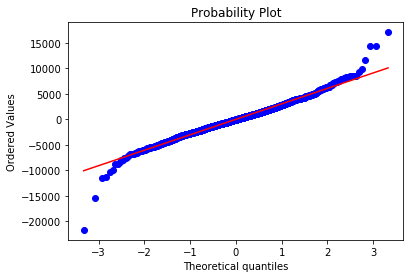

In [149]:
## q-qPlot
fig = plt.figure()
res = stats.probplot(sarimax_100_111.resid, dist="norm", plot=pylab)

* Hypothesis of normality can be rejected

In [151]:
print(sarimax_100_111.summary())

                                 Statespace Model Results                                
Dep. Variable:                     EnergyConsump   No. Observations:                 1581
Model:             SARIMAX(1, 0, 0)x(1, 1, 1, 7)   Log Likelihood              -14868.708
Date:                           Mon, 25 Sep 2017   AIC                          29753.416
Time:                                   18:52:06   BIC                          29796.343
Sample:                               01-01-2011   HQIC                         29769.366
                                    - 04-30-2015                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Temp1        112.7736     30.711      3.672      0.000      52.582     172.965
Temp2       -218.8168     28.248     -7.746

## 5) Forecast is build for initial TS

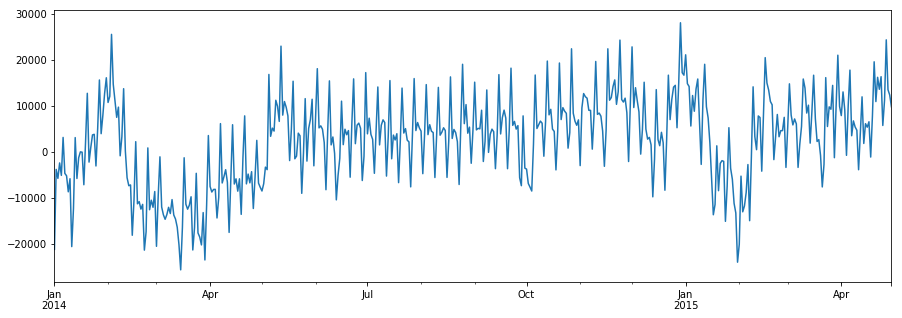

In [156]:
fig, ax = plt.subplots(figsize=(15,5),  linewidth=3.0)
fig = sarimax_100_111.predict(start='2014-01-01', end='2015-04-30', ax=ax).plot()
# legend = ax.legend(loc='upper left')

In [153]:
# fig, ax = plt.subplots(figsize=(15,8),  linewidth=3.0)
# fig = arima_mod710_ex.plot_forecast(185)
frc =sarimax_100_111.forecast(steps = 13, exog = extra_exogs[extra_exogs.index>='2015-05-01'])

In [154]:
frc_arimax = extra_exogs[extra_exogs.index>='2015-05-01']
frc_arimax['FRC'] = frc[0]
# frc_arimax['EnergyConsump'] = ts[ts.index>='2015-05-01'] 

C:\Users\rusrom.EUROPE\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



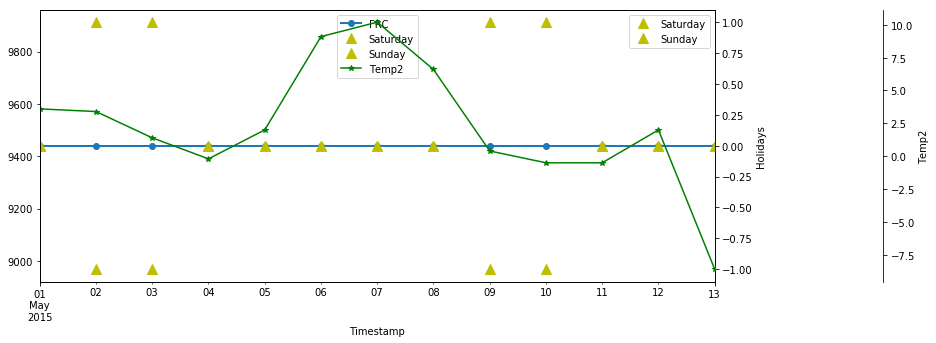

In [155]:
fig, ax = plt.subplots(figsize=(15,5))

ax2, ax3 = ax.twinx(), ax.twinx()
ax2.set_ylabel('Holidays')
rspine = ax3.spines['right']
rspine.set_position(('axes', 1.25))
ax3.set_frame_on(True)
ax3.patch.set_visible(False)
ax3.set_ylabel('Temp2')
fig.subplots_adjust(right=0.75)

frc_arimax[['FRC']].tail(186).plot(ax = ax,marker = 'o', linewidth=2.0)
frc_arimax[['Saturday', 'Sunday']].tail(186).plot(ax = ax2, style='y', marker = '^', markersize = 10.0, linewidth=0.0)
frc_arimax['Temp2'].tail(186).plot(ax = ax3,  style='g-', marker='*')

lines = ax.get_lines() + ax2.get_lines() + ax3.get_lines()
ax.legend(lines, [l.get_label() for l in lines], loc='upper center')

In [ ]:
# Practice: build the forecast of original TS


In [ ]:
# Practice: calculate MAPE for dates > 2015-05-01


<h1 align="center"> Practice: realize compositions</h1>
# Adaptive selection
** Question:**
* What is adaptive selection?
* Which external parameters does it have?
* Describe case when adaptive selection works bad.

In [72]:
def adaptive_selection(x, h, params):
'''
Parameters
x <array> - time series
h <integer scalar>- forecasting delay
params <dict> - dictionary with 
    gamma <scalar in [0,1]> - smoothing parameter of error
    eps <scalar> - bound for best indistinctive models
    base_algs - array of <dict> with params
        base_alg <string> - name of base algorithm
        BaseAlfParams <dict> dictionary of base algorithm's params
'''
    T = len(x)
    FORECAST = [np.NaN]*(T+h)

    
    
    # Base Algs Forecasts     
    base_algs = params.base_algs
    N = len(base_algs)
    FORECAST_BA = np.array([np.NAN]*(T+h)*N).reshape(N, T+h)
    
    
    #     forecast TS by each base algs
    #     be careful with eval() function    
    for ba in range(len(base_algs)):
        FORECAST_BA[BA]= eval(base_algs[ba]['base_alg']+"(x,h,"+"base_algs["+str(ba)+"]['base_alg_params'])")
    
    # internal params of composition
    gamma = params['gamma']
    eps = params['eps']
    
    if gamma>1:
        w.warn('Gamma can not be more than 1')
        #alpha = 1
        return FORECAST
    if gamma<0:
        w.warn('Gamma can not be less than 0')
        #alpha = 0
        return FORECAST

    
    e1= [0]*N  # initialization of errors of base algorithms 
    j_best = [0]*N
    
    
    for t in range(0, T):
        if not math.isnan(x[t]):
            
            if t>= h:
                'TODO: check this code'
                e1 = gamma*np.abs(x[t]-FORECAST_BA.transpose()[t])+(1-gamma)*e1  
           
                # select best algorithm at the moment t
                j_best = 'TODO: find index of best base alg'
                # select best indistinctive 
                idx_bestinsdistinctive = 'TODO: find indexes of best indistinctive algorithms'
    
                y = FORECAST_BA.transpose()[idx_bestinsdistinctive].mean()
                # else do nothing
#         else do nothing
            
            
        FORECAST[t+h] = y
    return FORECAST

# Adaptive composition
** Question:**
* What is adaptive composition?
* Which external parameters does it have?
* Describe case when adaptive selection works 

In [ ]:
def adaptive_composition(x, h, params):
'''
Parameters
x <array> - time series
h <integer scalar>- forecasting delay
params <dict> - dictionary with 
    gamma <scalar in [0,1]> - smoothing parameter of error
    base_algs - array of <dict> with params
        base_alg <string> - name of base algorithm
        base_alg_params <dict> dictionary of base algorithm's params
'''
    T = len(x)
    FORECAST = [np.NaN]*(T+h)

    
    
    # Base Algs Forecasts     
    base_algs = params.base_algs
    N = len(base_algs)
    FORECAST_BA = np.array([np.NAN]*(T+h)*N).reshape(N, T+h)
    
    
    #     forecast TS by each base algs
    #     be careful with eval() function    
    for ba in range(len(base_algs)):
        FORECAST_BA[BA]= eval(base_algs[ba]['base_alg']+"(x,h,"+"base_algs["+str(ba)+"]['base_alg_params'])")
    
    # internal params of composition
    gamma = params['gamma']
    eps = params['eps']
    
    if gamma>1:
        w.warn('Gamma can not be more than 1')
        #alpha = 1
        return FORECAST
    if gamma<0:
        w.warn('Gamma can not be less than 0')
        #alpha = 0
        return FORECAST

    
    e1= [0]*N  # initialization of errors of base algorithms 
    weights = [0]*N
    
    for t in range(0, T):
        if not math.isnan(x[t]):
            
            if t>= h:
                e1 = gamma*np.abs(x[t]-FORECAST_BA.transpose()[t])+(1-gamma)*e1
           
                # select best algorithm at the moment t
                w_best = 'TODO: calculate weights of base algorithms'
                
#               Calculate forecast of the composition
                y = FORECAST_BA.transpose()[j_best].mean()
                # else do nothing
#         else do nothing
            
            
        FORECAST[t+h] = y
    return FORECAST

In [2]:
base_algs = [{'base_alg':'InitExponentialSmoothing', 'base_alg_params':{'alpha':0.1, 'AdaptationPeriod':10}},
            {'base_alg':'AdaptiveExponentialSmoothing', 'base_alg_params':{'alpha':0.2,'gamma':0.01, 'AdaptationPeriod':10}}
#                  {'base_alg':'AdaptiveSimpleExponentialSmoothing', 'base_alg_params':{'alpha':0.1, 'gamma':0.01}},
#                 {'base_alg':'TheilWageSmoothing', 'base_alg_params':{'alpha':0.3, 'beta':0.9,'delta':0.9}}
]

In [3]:
for ba in range(len(base_algs)):
    print(base_algs[ba]['base_alg']+"(x,h,"+"base_algs["+str(ba)+"]['base_alg_params'])")

SimpleExponentialSmoothing(x,h,base_algs[0]['base_alg_params'])
AdaptiveExponentialSmoothing(x,h,base_algs[1]['base_alg_params'])


In [4]:
ts = pd.read_csv('../2_ts_arima/data/TimeSeries_Data10.csv', sep=',', decimal='.', parse_dates=True, dayfirst=True, index_col='Dates')
ts.index.names=['Timestamp']
# ts = pd.read_csv('./data/TimeSeries_Data10.csv', sep=',', decimal='.')
ts = ts.sort_index() # sort index

In [6]:
h =1 
frc_ts = pd.DataFrame(index = ts.index.append(pd.date_range(ts.index[-1]+timedelta(1), ts.index[-1]+timedelta(h)))
                      , columns = ts.columns)
FRC_TS = dict()

In [10]:
# run Adaptive Selection
gamma=0.01
eps = 1.0

for cntr in ts.columns:
    frc_ts[cntr]= adaptive_selection(ts[cntr],h, {'gamma':gamma, 'eps': eps, 'base_alg_params':base_algs})
FRC_TS['AS gamma %.2f eps %.2f' % (gamma, eps)] = frc_ts

In [51]:
# run Adaptive Composition
gamma=0.01

for cntr in ts.columns:
    frc_ts[cntr]= adaptive_composition(ts[cntr],h, {'gamma':gamma, 'base_alg_params':base_algs})
FRC_TS['AC gamma %.2f' % (gamma)] = frc_ts

In [ ]:
# plot loss of compositions
ix = range(100)
# compare ES methods in first 100 steps
QualityStr = pd.DataFrame(index = ts.columns, columns = sorted(FRC_TS.keys()))

for model in QualityStr.columns:
    frc_ts = FRC_TS[model]
    for ts_num in ts.columns:
        ix = pd.date_range(ts[ts_num].first_valid_index(), ts[ts_num].first_valid_index()+timedelta(50))
        QualityStr[model][ts_num],_ = qualityMACAPE(ts[ts_num].loc[ix], frc_ts[ts_num].loc[ix])

QualityStr[sorted(QualityStr.columns)[:1]].mean().plot(label='adaptive_composition', linewidth=2.0)
QualityStr[sorted(QualityStr.columns)[1:2]].mean().plot(label='adaptive_selection', linewidth=2.0)

plt.legend()

# Aggregating Algorithm
** Question:**
* What is aggregating algorithm?
* What is a mixable game?
* Descibe parameters of AA:
    - $\beta$ - parametr of mixability
    - $S(g)$ - substitution function
    - $p_j$ - initial distribution of base algorithms
* Write down theoretical boundary for AA

In [ ]:
def aa_composition(x, h, params):
'''
Parameters
x <array> - time series
h <integer scalar>- forecasting delay
params <dict> - dictionary with 
    beta <scalar in [0,1]> - mixability parameter 
    weights <array in [0,1]> - initial weights of base_algs
    base_algs - array of <dict> with params
        base_alg <string> - name of base algorithm
        base_alg_params <dict> dictionary of base algorithm's params
'''
    T = len(x)
    FORECAST = [np.NaN]*(T+h)

    
    
    # Base Algs Forecasts     
    base_algs = params.base_algs
    N = len(base_algs)
    FORECAST_BA = np.array([np.NAN]*(T+h)*N).reshape(N, T+h)
    
    
    #     forecast TS by each base algs
    #     be careful with eval() function    
    for ba in range(len(base_algs)):
        FORECAST_BA[BA]= eval(base_algs[ba]['base_alg']+"(x,h,"+"base_algs["+str(ba)+"]['base_alg_params'])")
    
    # internal params of composition
    beta = params['beta']
    weights = params['weights']
    
    if beta>1:
        w.warn('Gamma can not be more than 1')
        #alpha = 1
        return FORECAST
    if beta<0:
        w.warn('Gamma can not be less than 0')
        #alpha = 0
        return FORECAST

           
    for t in range(0, T):
        if not math.isnan(x[t]):
            
            if t>= h:
                weights = 'TODO: update weights'
           
                
#               Calculate forecast of the composition
                y = 'Substitution function'
                
         else:
            y = 'Substitution function'
            
        FORECAST[t+h] = y
    return FORECAST

In [ ]:
h =1 
base_algs = [{'base_alg':'InitExponentialSmoothing', 'base_alg_params':{'alpha':0.1, 'AdaptationPeriod':10}},
            {'base_alg':'AdaptiveExponentialSmoothing', 'base_alg_params':{'alpha':0.2,'gamma':0.01, 'AdaptationPeriod':10}}
frc_ts = pd.DataFrame(index = ts.index.append(pd.date_range(ts.index[-1]+timedelta(1), ts.index[-1]+timedelta(h)))
                      , columns = ts.columns)
FRC_TS = dict()

for cntr in ts.columns:
    frc_ts[cntr]= aa_composition(ts[cntr],h, {'beta':0.9, 'weiths': np.array([0.5,0.5]), 'base_alg_params':base_algs})
FRC_TS['AA beta %.2f' % (beta)] = frc_ts

<h1 align="center"> Conclusion </h1>

** you can find HW3 here** 
  * оцените <a href="https://goo.gl/forms/SIa0Elv5PrrEnwwa2"> семинар </a>